In [1]:
! pip install pyro-ppl

In [2]:
import random
import string
import os
import itertools
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.distributions.utils import probs_to_logits
from utils import *

In [3]:
pcfg = {
  "name": "astronomers",
  "terminals": ["astronomers", "ears", "saw", "stars", "telescopes", "with"],
  "non_terminals": ["S", "NP", "VP", "PP", "P", "V"],
  "productions": {
    "S": [["NP", "VP"]],
    "NP": [["NP", "PP"], ["astronomers"], ["ears"], ["saw"], ["stars"], ["telescopes"]],
    "VP": [["V", "NP"], ["VP", "PP"]],
    "PP": [["P", "NP"]],
    "P": [["with"]],
    "V": [["saw"]]
  },
  "start_symbol": "S",
}
true_production_probs = {
    "S": [1.0],
    "NP": [0.4, 0.1, 0.18, 0.04, 0.18, 0.1],
    "VP": [0.7, 0.3],
    "PP": [1.0],
    "P": [1.0],
    "V": [1.0]
}
max_depth_parse_tree = 20
slient = True
terminate_symbol = "__"

In [4]:
prior_production_logits = {
    k: torch.randn((len(v),)) 
    for k, v in pcfg['productions'].items()
}
ground_truth_production_logits = {
    k: probs_to_logits(torch.tensor(true_production_probs[k]))
    for k, v in pcfg['productions'].items()
}
if not slient:
    print(prior_production_logits)
    print(ground_truth_production_logits)

In [5]:
def generate_sentences(production_logits):
    
    def sample_parse_tree(symbol = None, depth = 0, suffix = "root"):
        if symbol is None:
            symbol = pcfg['start_symbol']
        if symbol in pcfg['terminals']:
            return symbol
        elif depth > max_depth_parse_tree:
            return terminate_symbol
        else:
            if not slient:
                print("symbol=>", symbol, production_logits[symbol])
            distribution = dist.Categorical(logits=production_logits[symbol])
            production_index = distribution.sample().detach()
            production = pcfg['productions'][symbol][production_index]
            return [symbol] + \
                [sample_parse_tree(s, depth=depth + 1, suffix = f"{suffix}_d{depth}/{i}") for i, s in enumerate(production)]
    tree = sample_parse_tree()
    if not slient:
        print("tree =>", tree)
    sentence = get_leaves(tree, max_depth_parse_tree, terminate_symbol)
    # how do we state observations, levenshtein distance?
    # may also use factor on levenshtein distance between gen and obs sentences and observe with 0

    # pad and normal distribution but very low sigma
    gen_sentence = pad_sentence(sentence_to_one_hots(sentence, pcfg["terminals"]), len(sentence))
    return sentence, gen_sentence, tree
if not slient:
    print(generate_sentences(prior_production_logits))
    print(generate_sentences(ground_truth_production_logits))

In [6]:
import model as model
import guide_lstm_v10 as guide

In [7]:
if not slient:
    model.model(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [8]:
obs_embedder_gru = nn.GRU(
    input_size=6,
    hidden_size=100,
    num_layers=1
)

def wrapped_guide(start_symbol='S', terminals=["astronomers", "ears", "saw", "stars", "telescopes", "with"], 
                  max_depth_parse_tree=20, terminate_symbol='__', observations={'obs': 0}):
    #print("print(observations['obs'].shape)", observations['obs'].shape)
    pyro.module('obs_embedder_gru', obs_embedder_gru)
    embedded_obs, _ = obs_embedder_gru(observations['obs'].unsqueeze(1))
    return guide.model(start_symbol, terminals, max_depth_parse_tree, terminate_symbol, {'obs' : embedded_obs[-1][0]})
if not slient:
    wrapped_guide(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [9]:
import tqdm
import matplotlib.pyplot as plt

In [10]:
pyro.clear_param_store()
smoke_test = False
n_steps = 10 if smoke_test else 20000
interval = 1 if smoke_test else 50
num_inference_samples = 2 if smoke_test else 10
optimiser = optim.Adam({"lr": 0.0005})
csis = pyro.infer.CSIS(model.model, wrapped_guide, optimiser, num_inference_samples=num_inference_samples)
avg_l = 0
loss_trace = []
steps = []

In [11]:
def print_weights(name, model):
    print("@params in", name)
    for param in model.parameters():
        print(param)
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [12]:
def draw_from_model(n=1000, ground_truth=True):
    logits = production_logits if not ground_truth else ground_truth_production_logits
    sample_sentences = [generate_sentences(logits) for _ in range(n)]
    return sample_sentences
sample_sentences = draw_from_model(n=n_steps)
if not slient:
    sample_sentences[0]

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n1 = count_parameters(guide._nn_model_sample_parse_tree_production_index_lstm)
n2 = count_parameters(guide._nn_model_sample_parse_tree_production_index_VP)
n3 = count_parameters(guide._nn_model_sample_parse_tree_production_index_NP)
n4 = count_parameters(obs_embedder_gru)
print(n1, n2, n3, n4, "total:", n1+n2+n3+n4)


98560 46589 47529 32400 total: 225078


  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_lstm_v10.py:176: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_VP_params,
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_lstm_v10.py:163: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_NP_params,
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [2:03:11<00:00,  2.71it/s]


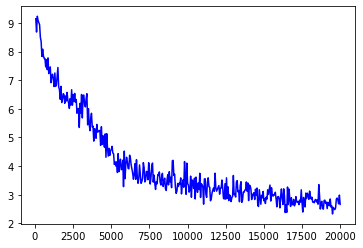

In [14]:
for step in tqdm.trange(n_steps):
    obs = sample_sentences[step]
    loss = csis.step(observations={"obs" : obs[1]})
    avg_l += loss
    if (step + 1) % interval == 0:
        steps.append(step)
        loss_trace.append(avg_l / interval)
        avg_l = 0

plt.plot(steps, loss_trace, "-b")
plt.show()

In [15]:
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [16]:
def drop_paddings(sentence_tensor):
    has_values = sentence_tensor.abs().sum(dim=-1).bool()
    return sentence_tensor[has_values]

In [17]:
def one_hot_sentence_to_list(sentence_tensor, terminals):
    sentence_np = sentence_tensor.cpu().detach().numpy()
    sentence_indices = np.argmax(sentence_np, axis=1)
    return [terminals[i] for i in sentence_indices]

In [18]:
def test(sentences, n=1):
    num_correct_n = 0
    num_correct_all = 0
    levenshtein_distances = {}
    for i in tqdm.trange(len(sentences)):
        obs = sentences[i]
        posterior = csis.run(observations={"obs" : obs[1]})
        marginal_ret = pyro.infer.EmpiricalMarginal(posterior)
        
        for i_sample in range(n):
            
            with torch.no_grad():
                _ret = marginal_ret()

            _ret = drop_paddings(_ret)
            num_correct_n += (torch.sum(obs[1]) == torch.sum(_ret))
            num_correct_all += torch.equal(obs[1], _ret)
            lev_dis = get_levenshtein_distance(one_hot_sentence_to_list(_ret, pcfg["terminals"]), 
                                               one_hot_sentence_to_list(obs[1], pcfg["terminals"]),
                                               pcfg["terminals"])
            if lev_dis in levenshtein_distances:
                levenshtein_distances[lev_dis] += 1
            else:
                levenshtein_distances[lev_dis] = 1
    
    avg_dis = 0  
    
    for k, v in levenshtein_distances.items():
        avg_dis += k * v

    return int(num_correct_n)  / len(sentences), int(num_correct_all) / len(sentences), levenshtein_distances, avg_dis / (len(sentences) * n)

example = ["astronomers", "saw", "stars", "with", "telescopes"]
example_sentence = sentence_to_one_hots(example, pcfg["terminals"])
print("example, n=1000", test([[None, example_sentence]], n=1000))
print("examples, 1000", test([[None, example_sentence]] * 1000))
print("train", test(sample_sentences[:1000]))
test_sentences = draw_from_model(n=1000)
print("test", test(test_sentences))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


example, n=1000 (1000.0, 1000.0, {0: 1000}, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:58<00:00,  5.59it/s]


examples, 1000 (1.0, 1.0, {0: 1000}, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:08<00:00,  2.33it/s]


train (0.746, 0.588, {0: 588, 24: 3, 11: 11, 20: 5, 2: 48, 15: 8, 6: 27, 10: 15, 7: 26, 12: 14, 18: 6, 1: 53, 4: 35, 17: 7, 8: 18, 14: 15, 3: 34, 23: 2, 5: 17, 9: 17, 13: 15, 19: 5, 29: 1, 31: 1, 30: 1, 16: 7, 37: 1, 45: 1, 22: 2, 43: 1, 25: 3, 21: 2, 51: 1, 39: 1, 47: 1, 34: 1, 36: 1, 26: 1, 32: 1, 53: 1, 27: 1, 41: 1, 35: 1}, 3.53)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:06<00:00,  2.34it/s]

test (0.771, 0.606, {32: 2, 0: 606, 18: 7, 5: 20, 8: 13, 19: 7, 3: 45, 51: 1, 4: 35, 26: 5, 9: 9, 2: 43, 6: 25, 24: 3, 7: 22, 10: 16, 1: 44, 13: 9, 31: 2, 12: 11, 44: 1, 11: 8, 27: 3, 14: 12, 15: 6, 53: 1, 22: 5, 23: 3, 17: 10, 37: 1, 16: 4, 20: 4, 28: 4, 34: 1, 29: 3, 21: 3, 45: 1, 46: 1, 25: 1, 30: 2, 36: 1}, 3.603)


In [19]:
test_sentences = draw_from_model(n=10000)
print("test", test(test_sentences))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:09:34<00:00,  2.40it/s]

test (0.7757, 0.6036, {26: 18, 0: 6036, 1: 633, 10: 130, 3: 346, 7: 232, 36: 8, 8: 134, 41: 8, 70: 2, 12: 103, 4: 290, 5: 258, 2: 454, 85: 2, 38: 9, 6: 213, 11: 128, 21: 47, 16: 69, 59: 2, 15: 75, 25: 31, 18: 37, 13: 92, 14: 76, 9: 143, 20: 28, 65: 1, 30: 17, 19: 51, 23: 44, 44: 4, 22: 25, 31: 20, 24: 29, 17: 53, 50: 3, 43: 5, 69: 2, 58: 3, 32: 13, 27: 14, 35: 9, 60: 3, 47: 3, 28: 19, 40: 6, 29: 10, 34: 8, 33: 7, 45: 4, 37: 6, 46: 4, 51: 4, 82: 1, 52: 3, 42: 5, 39: 7, 61: 2, 49: 2, 48: 2, 73: 1, 53: 1, 55: 1, 54: 1, 63: 1, 72: 1, 66: 1}, 3.4999)


In [20]:
example2 = ["stars", "saw"]
get_levenshtein_distance(example, example2, pcfg["terminals"])

4

In [21]:
print(loss_trace)

[9.145203939080238, 8.681710107326507, 9.234358251690864, 9.083835995197296, 9.010718514323235, 8.93733043909073, 8.493409923762083, 8.35929221689701, 7.829272535741329, 8.083282369971275, 7.85352166235447, 7.758481364995241, 7.757602606937289, 7.466222428157925, 7.718033605888486, 7.366822292283177, 7.779114957787097, 7.23117456048727, 7.42996118943207, 7.46296372435987, 6.913359271716327, 7.1573841615673155, 7.208985071349889, 7.032093967758119, 6.7778665717551485, 7.252388227768242, 6.784566592476331, 6.831445486359298, 7.128503136113286, 7.445167839629575, 6.7652667588158515, 6.674035020465962, 6.335831540455111, 6.785700145254378, 6.218891270101303, 6.322028239893261, 6.527634328543209, 6.4929848725046035, 6.193166098379297, 6.449426729925908, 6.2727024960401465, 6.572341623193352, 6.3040940621087795, 6.20241414462449, 6.013883780441247, 6.354279046284501, 6.1310103767598045, 6.667125347000547, 6.12826103929081, 6.498961089092773, 6.2519853211048755, 6.537951517742476, 6.233983351

In [22]:
print(min(loss_trace), loss_trace.index(min(loss_trace)))

2.327905615664217 389


In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n1 = count_parameters(guide._nn_model_sample_parse_tree_production_index_lstm)
n2 = count_parameters(guide._nn_model_sample_parse_tree_production_index_VP)
n3 = count_parameters(guide._nn_model_sample_parse_tree_production_index_NP)
n4 = count_parameters(obs_embedder_gru)
print(n1, n2, n3, n4, "total:", n1+n2+n3+n4)


98560 46589 47529 32400 total: 225078
